In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
filename = '/content/drive/MyDrive/Brazilian/brazilian.zip'
with ZipFile(filename,'r')  as zip:
  zip.extractall()
  print('run ')


run 


In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import cv2
import glob
import os
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
net = models.vgg16(pretrained=True)
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(4096,1024),
    nn.Dropout(0.5),
    
    nn.Linear(1024,40),
    nn.LogSoftmax(dim=1)
    
)
net.classifier = fc
net.to(device)
print(device)

cuda:0


In [3]:
file1 = open("/content/drive/MyDrive/DL/Copy of label_brazsign.txt","r+")
labels = file1.readlines()
Dict = {}
for  i in labels:
    Dict[i.split(' ')[1][:-1]] = int(i.split(' ')[0])
print(Dict)

{'1': 0, '2': 1, '4': 2, '5': 3, '7': 4, '9': 5, 'A': 6, 'Adulto': 7, 'America': 8, 'Aviao': 9, 'B': 10, 'C': 11, 'Casa': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'Gasolina': 17, 'I': 18, 'Identidade': 19, 'Junto': 20, 'L': 21, 'Lei': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Palavra': 27, 'Pedra': 28, 'Pequeno': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'Verbo': 36, 'W': 37, 'X': 38, 'Y': 39}


In [4]:
transform =transforms.Compose([transforms.ToPILImage(),transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [5]:
class HandRecDataset():
    def __init__(self, label_dict, root_dir):
        self.label_dict = label_dict  
        self.root_dir = root_dir
        self.file_path =[]
        for filename  in glob.iglob(root_dir+"/*/*.PNG"):
          if(self.root_dir=='brazilian/train'):
            self.file_path.append(filename)
          else:
            if not os.path.basename(filename).startswith('a'):
              self.file_path.append(filename)
              
    def __len__(self):
        return len(self.file_path)

    def __getitem__(self, idx):
        file_name = self.file_path[idx]
        img = cv2.imread(file_name)
        label_key=file_name.split('/')[-2]
        label =self.label_dict[label_key]
        out =transform(img).cuda()
        return out,label

In [6]:
train_hand_dataset = HandRecDataset(label_dict=Dict,root_dir='brazilian/train')
test_hand_dataset = HandRecDataset(label_dict=Dict,root_dir='brazilian/test')
val_hand_dataset = HandRecDataset(label_dict=Dict,root_dir='brazilian/valid/')
batch_size=64
train_loader = torch.utils.data.DataLoader(train_hand_dataset, batch_size=batch_size,shuffle =True)
validation_loader = torch.utils.data.DataLoader(val_hand_dataset, batch_size=batch_size,shuffle =True)
test_loader = torch.utils.data.DataLoader(test_hand_dataset, batch_size=40,shuffle =True)

In [7]:
train_hand_dataset[1][0].shape

torch.Size([3, 224, 224])

In [8]:
def validate():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100 * correct / total)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)
acc =0

In [10]:
len(train_hand_dataset)

90000

In [14]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels =labels.cuda()
     
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
       
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f accuracy : %.1f' %
                  (epoch + 1, i + 1, running_loss / 10,100 * correct / total))
            running_loss = 0.0
    val = validate()
    print(val)
    if val>acc:
        acc = val
        torch.save(net.state_dict(), 'VGGNET.pth')

print('Finished Training')

KeyboardInterrupt: ignored

In [ ]:
acc

In [15]:
net.load_state_dict(torch.load('VGGNET.pth'))
net.eval()
y_classes = torch.zeros([800], dtype=torch.int32)
y_predic = torch.zeros([800], dtype=torch.int32)
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            images, labels = data
            y_classes[i*40:i*40+40] =labels
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_predic[i*40:i*40+40] = predicted
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100 * correct / total)

In [16]:
print(test())

84.375


Accuracy Score : 0.84375
Confusion Matrix : 
[[20  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0  0]]
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.00      0.00      0.00        20
           2       1.00      0.70      0.82        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      0.95      0.97        20
           6       0.00      0.00      0.00        20
           7       0.87      1.00      0.93        20
           8       1.00      1.00      1.00        20
           9       0.95      1.00      0.98        20
          10       0.50      0.05      0.09        20
          11       0.83      1.00      0.91        20
          12       1.00      1.00      1.00        20
          13       0.95      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


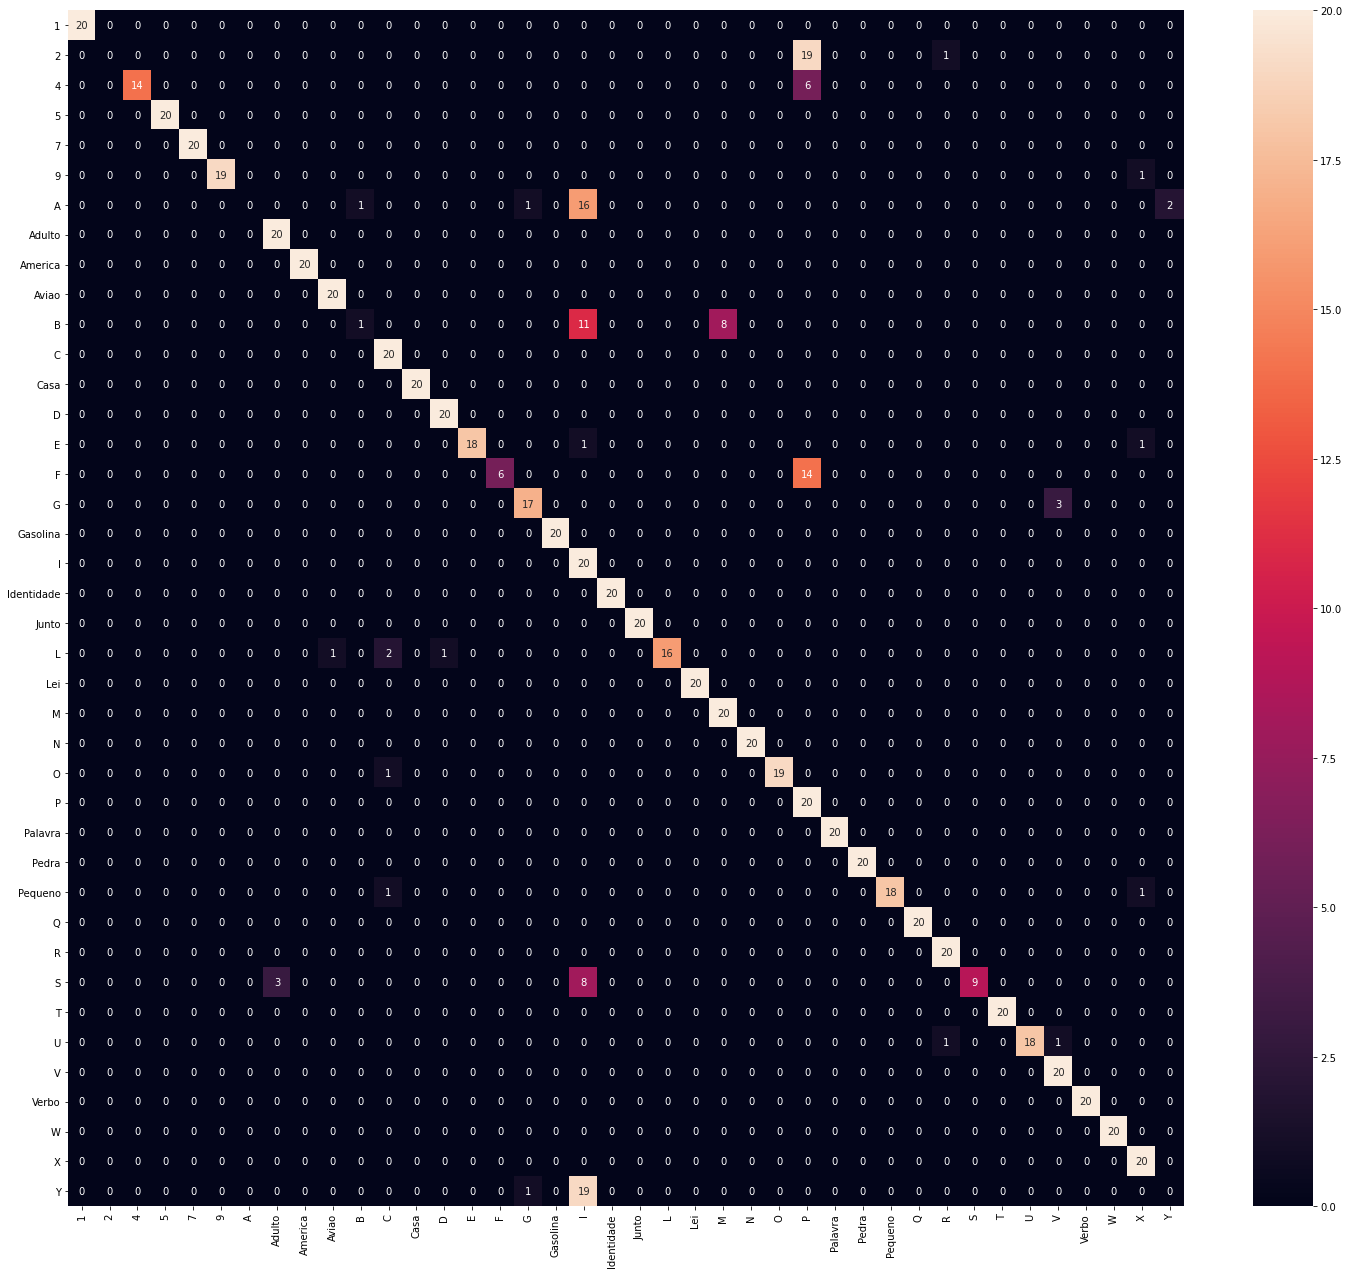

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
con_mat=confusion_matrix(y_classes, y_predic)
print ('Accuracy Score :',accuracy_score(y_classes, y_predic) )
print ('Confusion Matrix : ')
print(con_mat)
classes = ['1','2','4','5','7','9','A','Adulto','America','Aviao','B','C','Casa','D','E','F','G','Gasolina','I','Identidade',
          'Junto','L','Lei','M','N','O','P','Palavra','Pedra','Pequeno','Q','R','S','T','U','V','Verbo','W','X','Y']
cm = pd.DataFrame(con_mat, index = classes,
                  columns = classes)
plt.figure(figsize = (25,22))
sn.heatmap(cm, annot=True)
print ('Report : ')
print (classification_report(y_classes, y_predic))